In [2]:
import matplotlib.pyplot as plt
import numpy as np

def draw_number(pixels):
    plt.figure()
    plt.imshow(pixels)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def load_emnist(key_path):
    import os
    if not os.path.isfile("~/.kaggle/kaggle.json"):
        !mkdir ~/.kaggle
        !mv {key_path} ~/.kaggle/kaggle.json
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install kaggle
        !kaggle datasets download -d crawford/emnist -p data

        import zipfile
        with zipfile.ZipFile("data/emnist.zip", 'r') as zip_ref:
            zip_ref.extractall("data/emnist")

def pad_images(images, target_size=(32, 32)):
    padded_images = np.zeros((images.shape[0], target_size[0], target_size[1], 1))
    padding = [(target_size[i] - images.shape[i + 1]) // 2 for i in range(2)]

    padded_images[:, padding[0]:padding[0] + images.shape[1], padding[1]:padding[1] + images.shape[2], :] = images
    return padded_images

In [3]:
load_emnist("kaggle.json")

mkdir: cannot create directory ‘/home/slinky/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.1 MB/s eta 0:00:000:00:01m eta 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.8 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=d16f9fb39e465776a73cbe62cd4e53f3b23abf514c1bcfe536c3ac7237b13008
  Stored in directory: /home/slinky/.cache/pip/wheels/6a/2b/d0/457dd27de499e9423caf738e743c4a3f82886ee6b19f89d5b7
Successfully built kaggle

[notice] A

In [4]:
import pandas as pd
from tf_keras import models
from tf_keras import layers

from tf_keras.callbacks import ModelCheckpoint, EarlyStopping
from tf_keras.utils import to_categorical

from keras_preprocessing.image import ImageDataGenerator

# Load the data
train = pd.read_csv('data/emnist/emnist-byclass-train.csv')
test = pd.read_csv('data/emnist/emnist-byclass-test.csv')

# Preprocess the data
train_labels = train.iloc[:, 0]
train_images = train.iloc[:, 1:]
test_labels = test.iloc[:, 0]
test_images = test.iloc[:, 1:]

train_images = train_images.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0

train_images = pad_images(train_images)
test_images = pad_images(test_images)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.90, 1.1], # This zooms both in and out
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(train_images)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
 
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(35, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
          epochs=50,  
          validation_data=(test_images, test_labels),
          steps_per_epoch=len(train_images) / 128,
          callbacks=[early_stopping, checkpoint])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

ImportError: /home/slinky/anaconda3/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/slinky/pythonenvs/gatornum/lib/python3.11/site-packages/tensorflow/python/platform/_pywrap_tf2.so)

Guessing: a
Actual: a


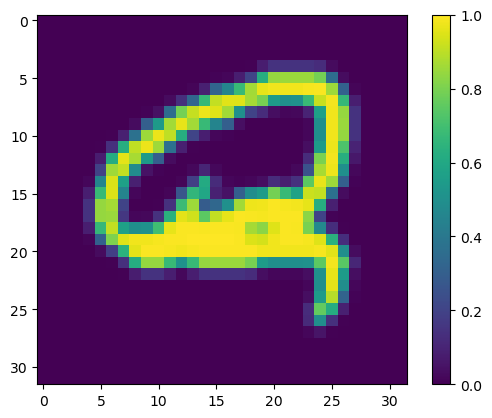





Guessing: 0
Actual: 0


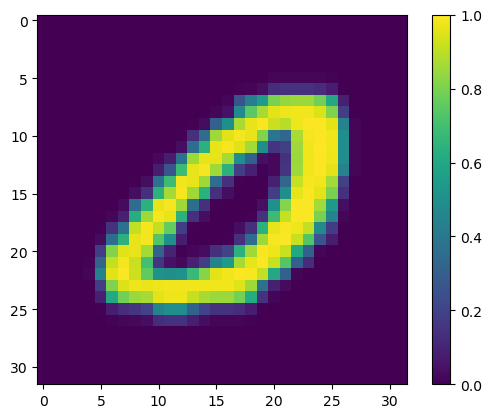





Guessing: 3
Actual: 3


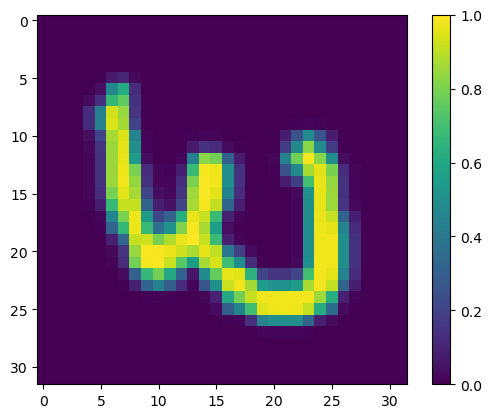





Guessing: X
Actual: X


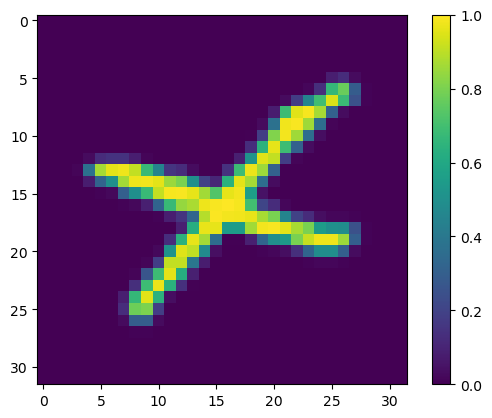





Guessing: U
Actual: U


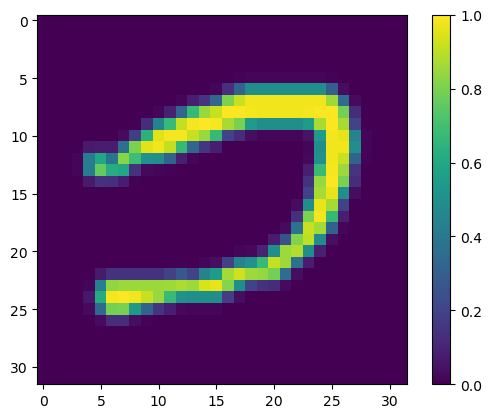

In [16]:
label_map = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

predictions = model.predict(test_images)

for i in range (0, 5):
    print(f"Guessing: {label_map[np.argmax(predictions[i])]}")
    print(f"Actual: {label_map[np.argmax(test_labels[i])]}")
    draw_number(test_images[i])
    print(f"\n\n\n")
